In [2]:
import pandas as pd #import important libraries
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error,mean_squared_error
import xgboost as xgb
from scipy import stats
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (r2_score, mean_absolute_error, mean_squared_error, accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix)
import optuna
from sklearn.model_selection import cross_val_score, KFold

In [16]:
df = pd.read_csv(r"C:\Users\Admin\Downloads\df_final_knn_imputed.csv") #read dataset

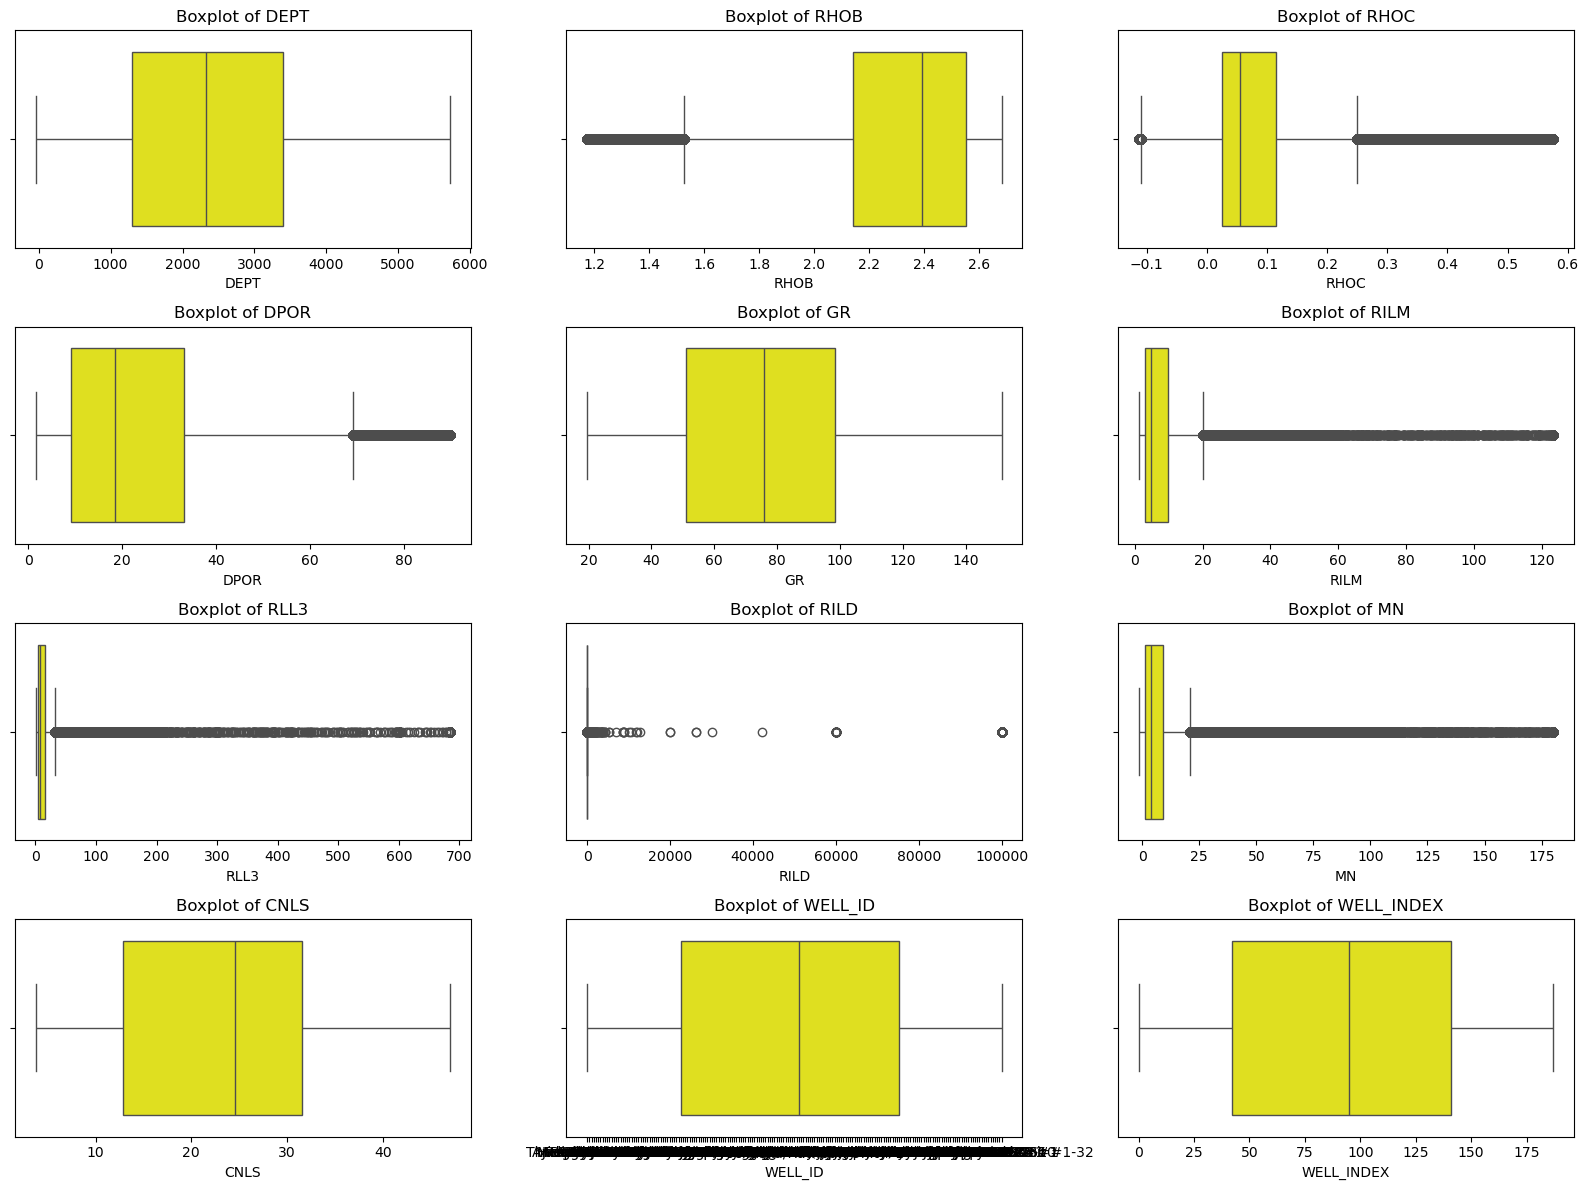

In [17]:
plt.figure(figsize=(16, 12)) #again plot boxplot. and we infer that there were no outliers after lmr and winsorization
for i, col in enumerate(df.columns):
    plt.subplot(4, 3, i + 1)
    sn.boxplot(x=df[col], color='yellow')
    plt.title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()

In [5]:
# Choose the column you want to check
column_name = 'sw'  # Replace with your column name

# Count number of rows where the column has value 1
count_ones = (df[column_name] == 1).sum()

# Print the result
print(f"Number of rows where '{column_name}' == 1:", count_ones)


Number of rows where 'sw' == 1: 935204


In [7]:
df.shape


(1900168, 12)

In [5]:
df_1 = pd.read_csv(r"C:\Users\Admin\all_wells_combined_all_features.csv")

In [7]:
print(df_1.head)

<bound method NDFrame.head of          ABHV  AVTX  BVTX      CILD     CNDL     CNLS  CNLSC    CNPOR  \
0         NaN   0.0   0.0    0.0000  24.8751  32.4589    NaN  32.4589   
1         NaN   0.0   0.0    0.0000  23.7977  31.7619    NaN  31.7619   
2         NaN   0.0   0.0    0.0000  20.0252  28.7654    NaN  28.7654   
3         NaN   0.0   0.0    0.0000  18.3094  27.2967    NaN  27.2967   
4         NaN   0.0   0.0    0.0000  26.1803  33.3129    NaN  33.3129   
...       ...   ...   ...       ...      ...      ...    ...      ...   
1900163   NaN   0.0   0.0  167.3475      NaN      NaN    NaN      NaN   
1900164   NaN   0.0   0.0  167.3254      NaN      NaN    NaN      NaN   
1900165   NaN   0.0   0.0  159.2450      NaN      NaN    NaN      NaN   
1900166   NaN   0.0   0.0  156.5618      NaN      NaN    NaN      NaN   
1900167   NaN   0.0   0.0  156.2113      NaN      NaN    NaN      NaN   

            CNSS  CNSSC  ...    RHOC         RILD      RILM    RLL3  RXORT  \
0        35.050

In [11]:
# only keeping imp columns
columns_to_keep = ['DEPT', 'RHOB', 'RHOC', 'DPOR', 'GR', 'RILM', 'RLL3', 'RILD', 'MN', 'CNLS', 'WELL_ID', 'WELL_INDEX']
df_filtered = df_1[columns_to_keep]

In [15]:
print(df_filtered.head)

<bound method NDFrame.head of            DEPT    RHOB    RHOC     DPOR       GR      RILM    RLL3  \
0         295.0  2.2592  0.1675  26.3624  74.5310  166.2761  1.0369   
1         295.5  2.2060  0.1353  29.4763  70.2132  194.9160  1.0366   
2         296.0  2.1844  0.1134  30.7349  71.4209  235.1570  1.0356   
3         296.5  2.2059  0.1003  29.4820  70.3895  294.3256  1.0340   
4         297.0  2.2077  0.0726  29.3733  69.4204  379.5092  1.0314   
...         ...     ...     ...      ...      ...       ...     ...   
1900163  4041.0     NaN     NaN      NaN      NaN    8.9913     NaN   
1900164  4041.5     NaN     NaN      NaN      NaN   11.3715     NaN   
1900165  4042.0     NaN     NaN      NaN      NaN   13.8405     NaN   
1900166  4042.5     NaN     NaN      NaN      NaN   16.4959     NaN   
1900167  4043.0     NaN     NaN      NaN      NaN   19.1478     NaN   

                RILD  MN     CNLS       WELL_ID  WELL_INDEX  
0        100000.0000 NaN  32.4589  Murphy #1-31        

In [23]:
#local median replacement: for each column, define the itervals, foreach interval find the median and replace it with the outliers present in that interval
# after local median replacement, apply global winsorization
from scipy.stats.mstats import winsorize

# ---------- STEP 1: Local Median Replacement ----------
def local_median_replacement(df_filtered, n_bins=10):
    df_transformed = df_filtered.copy()
    numeric_cols = df_filtered.select_dtypes(include=np.number).columns

    for col in numeric_cols:
      col_values = df_filtered[col].dropna()
      bins = pd.qcut(col_values, q=n_bins, duplicates='drop')
      for interval in bins.unique():
          bin_mask = bins == interval
          bin_values = col_values[bin_mask]

          Q1 = bin_values.quantile(0.25)
          Q3 = bin_values.quantile(0.75)
          IQR = Q3 - Q1
          lower = Q1 - 1.5 * IQR
          upper = Q3 + 1.5 * IQR
          bin_median = bin_values.median()

          outlier_mask = (df_filtered[col].between(interval.left, interval.right)) & \
                        ((df_filtered[col] < lower) | (df_filtered[col] > upper))

          df_transformed.loc[outlier_mask, col] = bin_median

    return df_transformed

# ---------- STEP 2: Global Winsorization ----------
def apply_global_winsorization(df_filtered, limits=(0.01, 0.01)):
    df_winsorized = df_filtered.copy()
    numeric_cols = df_filtered.select_dtypes(include=np.number).columns

    for col in numeric_cols:
        col_series = df_filtered[col]
        mask = col_series.notna()
        winsorized_values = winsorize(col_series[mask], limits=limits)

        # Reassign only to the non-null positions
        df_winsorized.loc[mask, col] = winsorized_values

    return df_winsorized

# ---------- FINAL EXECUTION ----------
df_local = local_median_replacement(df_filtered, n_bins=10)           # Local median replacement on a copy
df_final = apply_global_winsorization(df_local, limits=(0.15, 0.15))  # Winsorization on the modified copy

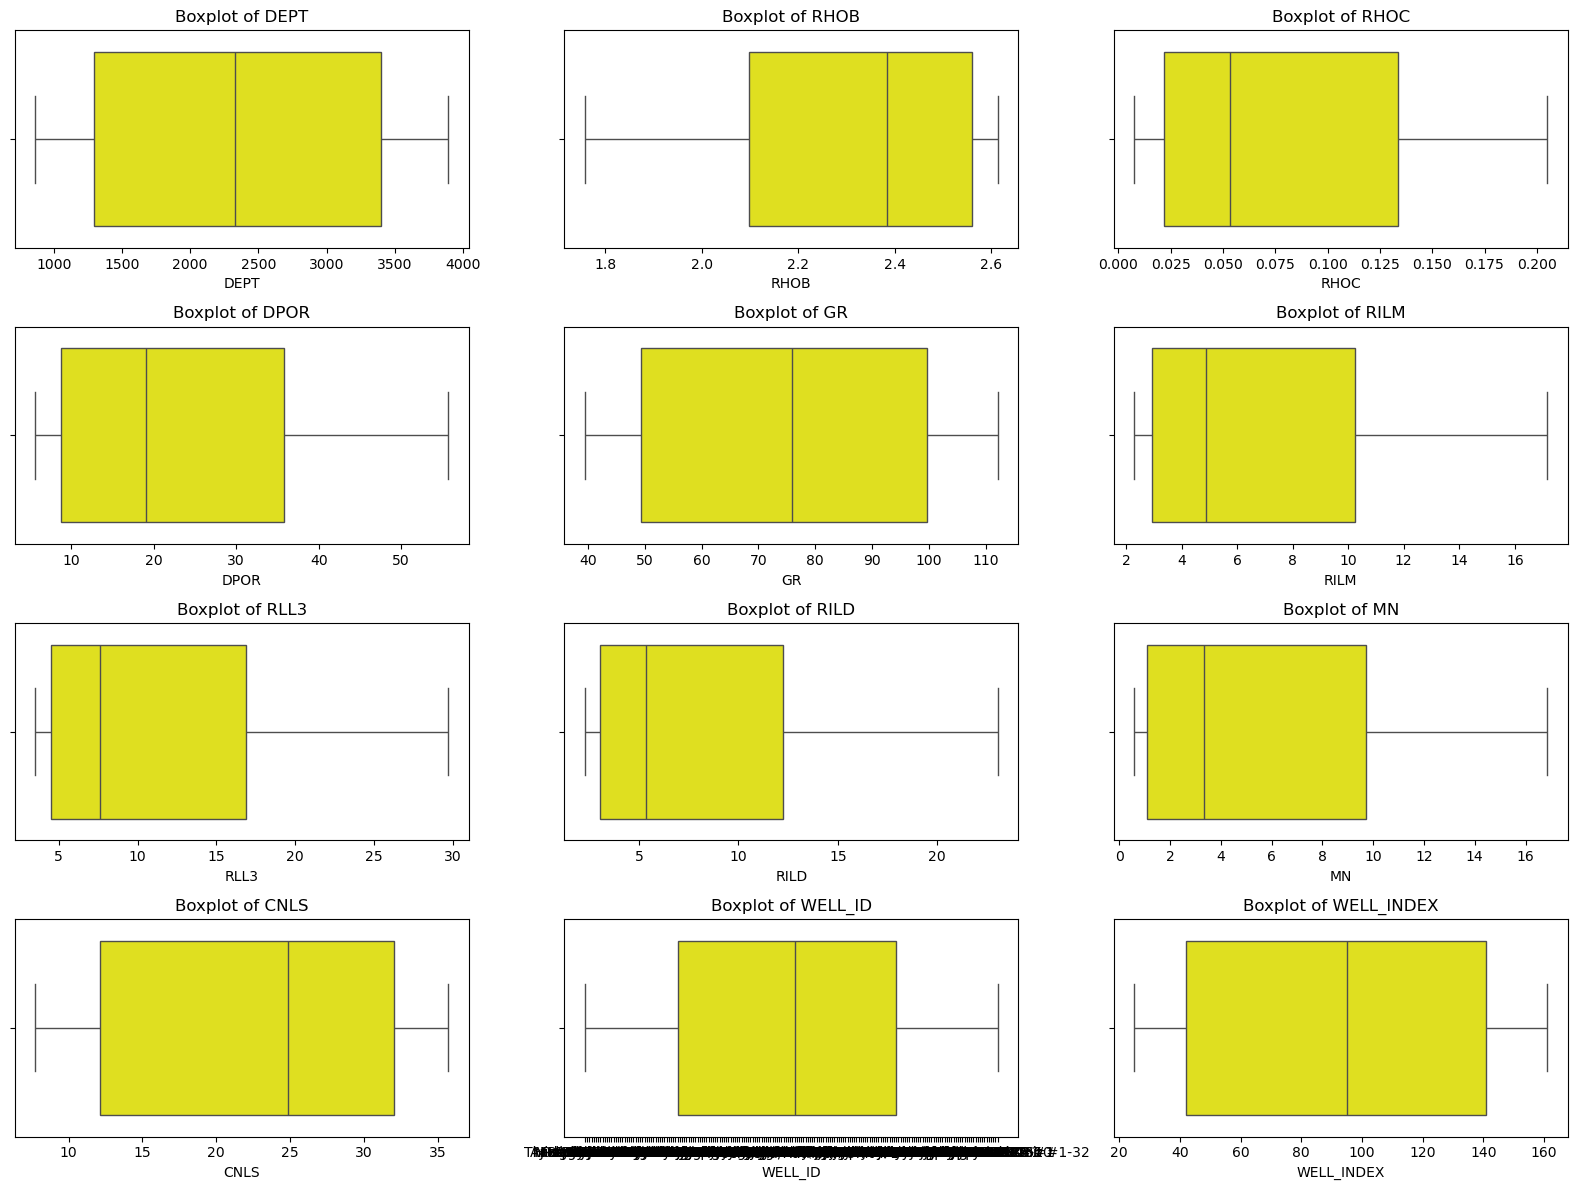

In [31]:
plt.figure(figsize=(16, 12)) #again plot boxplot. and we infer that there were no outliers after lmr and winsorization
for i, col in enumerate(df_final.columns):
    plt.subplot(4, 3, i + 1)
    sn.boxplot(x=df_final[col], color='yellow')
    plt.title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()

In [33]:
print(df_final.isnull().sum().sum())  # Total count of nulls in the entire DataFrame
print(df_final.isnull().sum())

386933
DEPT               0
RHOB           44732
RHOC           44841
DPOR           44729
GR             18533
RILM            1203
RLL3           12642
RILD             720
MN            177939
CNLS           41594
WELL_ID            0
WELL_INDEX         0
dtype: int64


In [45]:
from sklearn.impute import KNNImputer
import pandas as pd
import numpy as np
import time

# ----- Configuration -----
chunk_size = 5000
well_id_col = 'WELL_ID'  # Change if your well ID column is named differently

# ----- Prepare for Imputation -----
numeric_cols = df_final.select_dtypes(include='number').columns
non_numeric_cols = df_final.select_dtypes(exclude='number').columns

df_final_knn = pd.DataFrame()

print("🔁 Starting KNN imputation for each well...\n")
overall_start = time.time()

# Loop over each well
for well_id, well_df in df_final.groupby(well_id_col):
    print(f"🛠 Processing Well ID: {well_id}  --> Total Rows: {len(well_df)}")

    # Select numeric data only
    numeric_df = well_df[numeric_cols]

    # Split into complete and missing
    df_complete = numeric_df.dropna()
    df_missing = numeric_df[numeric_df.isnull().any(axis=1)]

    if df_missing.empty:
        print(f"✅ No missing data for Well ID: {well_id}. Skipping imputation.")
        df_imputed = well_df.copy()
    else:
        # Fit KNN on complete rows
        imputer = KNNImputer(n_neighbors=5, weights='uniform')
        imputer.fit(df_complete)

        # Impute missing rows in chunks
        imputed_chunks = []
        total_missing = df_missing.shape[0]
        for start_idx in range(0, total_missing, chunk_size):
            end_idx = min(start_idx + chunk_size, total_missing)
            chunk = df_missing.iloc[start_idx:end_idx]
            imputed_chunk = imputer.transform(chunk)
            imputed_chunks.append(imputed_chunk)

        df_missing_imputed = pd.DataFrame(
            np.vstack(imputed_chunks),
            columns=numeric_cols,
            index=df_missing.index
        )

        # Combine complete + imputed
        df_imputed_numeric = pd.concat([df_complete, df_missing_imputed]).sort_index()

        # Add back non-numeric columns
        # df_imputed = well_df.copy()
        # df_imputed[numeric_cols] = df_imputed_numeric

        # Correct way to rebuild final well DataFrame
        df_imputed = well_df.copy()
        df_imputed[numeric_cols] = df_imputed_numeric[numeric_cols]

    df_final_knn = pd.concat([df_final_knn, df_imputed], axis=0)

total_time = time.time() - overall_start
print(f"\n✅ All wells processed. Total time: {round(total_time, 2)} seconds")

🔁 Starting KNN imputation for each well...

🛠 Processing Well ID: 1055282622  --> Total Rows: 5822
🛠 Processing Well ID: Alexa #2  --> Total Rows: 18434
🛠 Processing Well ID: Amber #1  --> Total Rows: 9161
🛠 Processing Well ID: Andrea #1  --> Total Rows: 18522
🛠 Processing Well ID: Antholz B #2-22  --> Total Rows: 10277
🛠 Processing Well ID: Audrey #1  --> Total Rows: 8791
🛠 Processing Well ID: BBS Unit #1-29  --> Total Rows: 8417
🛠 Processing Well ID: Beams #1-20  --> Total Rows: 7401
🛠 Processing Well ID: Bellerive A #2-29  --> Total Rows: 7821
🛠 Processing Well ID: Bender 'B' #21-1  --> Total Rows: 5241
🛠 Processing Well ID: Blattner #1-28  --> Total Rows: 10725
🛠 Processing Well ID: Bollig A #4  --> Total Rows: 7791
🛠 Processing Well ID: Bonnie #1  --> Total Rows: 11622
🛠 Processing Well ID: Boxberger H #19  --> Total Rows: 5667
🛠 Processing Well ID: Brandenstein A-1  --> Total Rows: 6121
🛠 Processing Well ID: Braun Family #1  --> Total Rows: 6821
🛠 Processing Well ID: Breanna #3  

In [47]:
print(df_final_knn.isnull().sum().sum())  # Total count of nulls in the entire DataFrame
print(df_final_knn.isnull().sum())

0
DEPT          0
RHOB          0
RHOC          0
DPOR          0
GR            0
RILM          0
RLL3          0
RILD          0
MN            0
CNLS          0
WELL_ID       0
WELL_INDEX    0
dtype: int64


In [51]:
print(df_final_knn.head)

<bound method NDFrame.head of            DEPT     RHOB     RHOC      DPOR         GR     RILM      RLL3  \
1263797  3185.5  2.44338  0.05724  15.59248   61.69454  17.1619  11.00546   
1263798  3185.0  2.44338  0.05724  15.59248   61.69454  17.1619  11.00546   
1263799  3184.5  2.44338  0.05724  15.59248   61.69454  17.1619  11.00546   
1263800  3184.0  2.44338  0.05724  15.59248   61.69454  17.1619  11.00546   
1263801  3183.5  2.44338  0.05724  15.59248   61.69454  17.1619  11.00546   
...         ...      ...      ...       ...        ...      ...       ...   
577379   3553.0  2.56950  0.11420   8.21920  106.73256  17.1619  15.88848   
577380   3553.5  2.54270  0.10490   9.78280  106.73256  17.1619  15.88848   
577381   3554.0  2.46060  0.07750  14.58350  106.73256  17.1619  15.88848   
577382   3554.5  2.48260  0.04870  13.29810  106.73256  17.1619  15.88848   
577383   3555.0  2.61310  0.00760   5.66690  106.73256  17.1619  15.88848   

             RILD       MN      CNLS     WELL

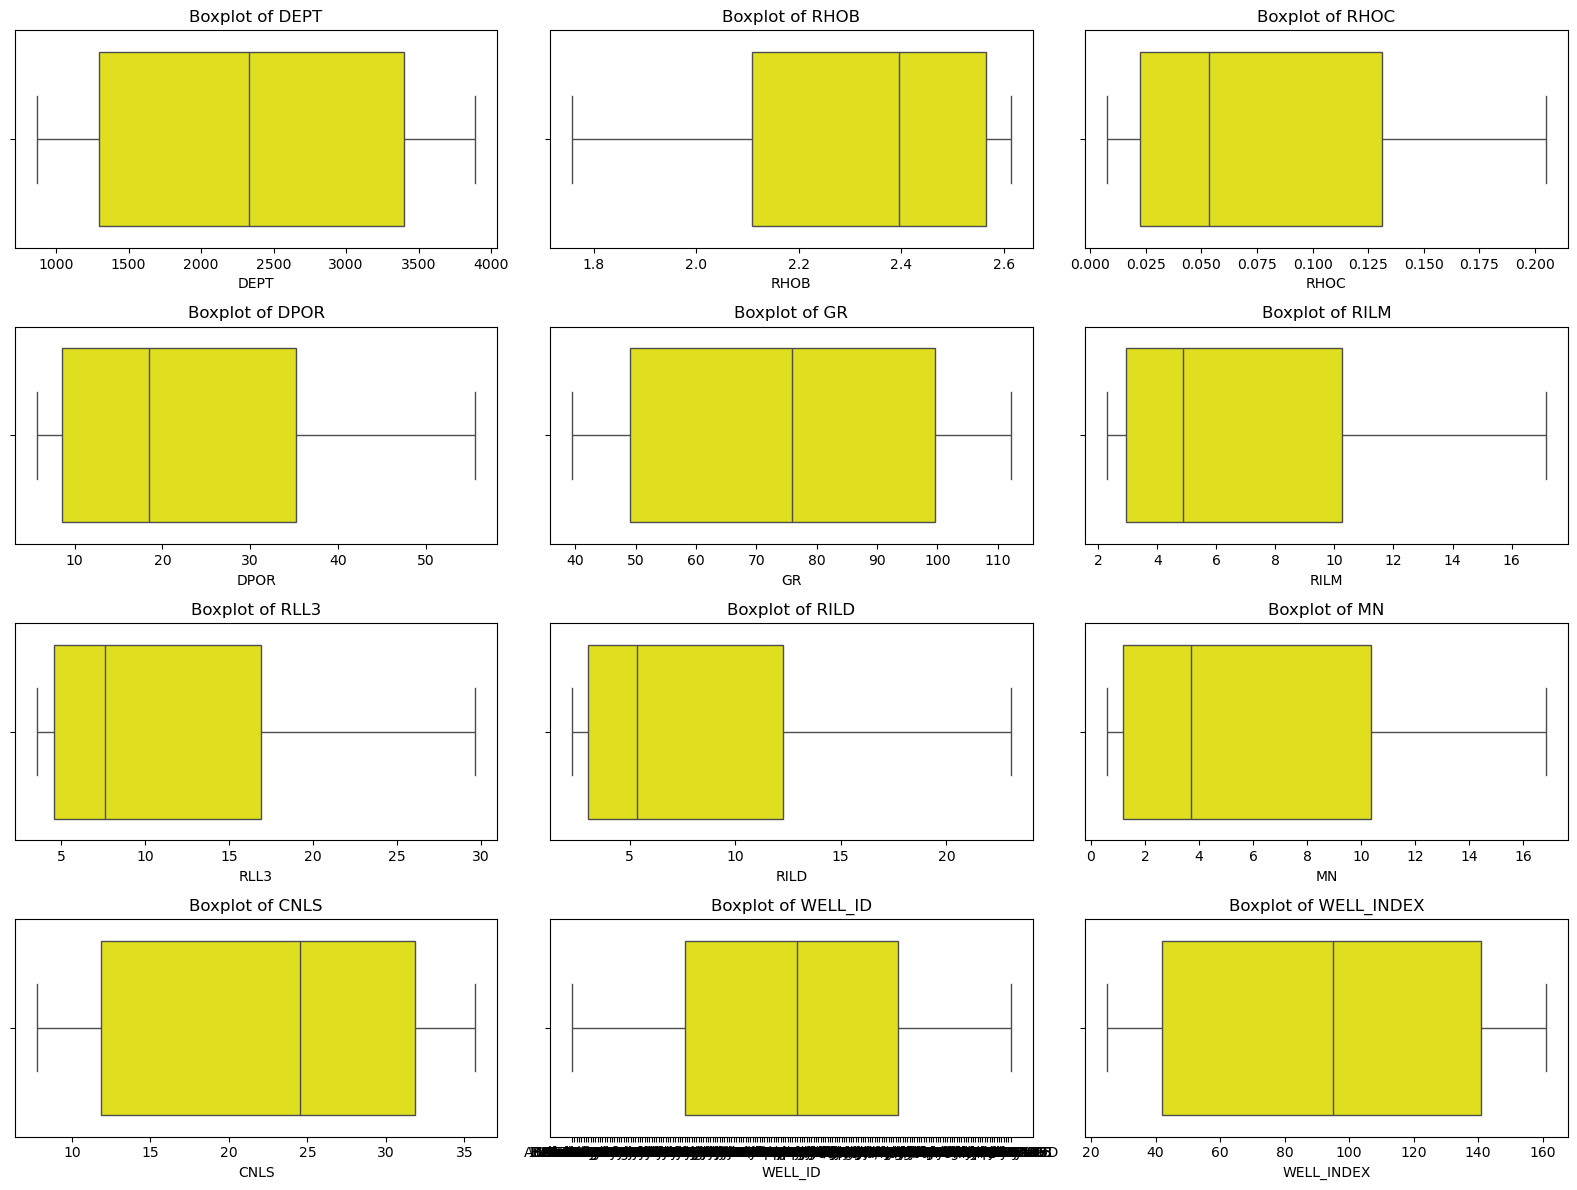

In [43]:
plt.figure(figsize=(16, 12)) #again plot boxplot. and we infer that there were no outliers after lmr and winsorization
for i, col in enumerate(df_final_knn.columns):
    plt.subplot(4, 3, i + 1)
    sn.boxplot(x=df_final_knn[col], color='yellow')
    plt.title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()

In [53]:
print(df_final_knn[['WELL_ID', 'WELL_INDEX']].drop_duplicates().head(10))

                   WELL_ID  WELL_INDEX
1263797         1055282622       124.0
1343435           Alexa #2       135.0
143751            Amber #1        25.0
25665            Andrea #1        25.0
8861       Antholz B #2-22        25.0
740542           Audrey #1        71.0
723724      BBS Unit #1-29        70.0
388596         Beams #1-20        37.0
894902   Bellerive A #2-29        90.0
97673     Bender 'B' #21-1        25.0


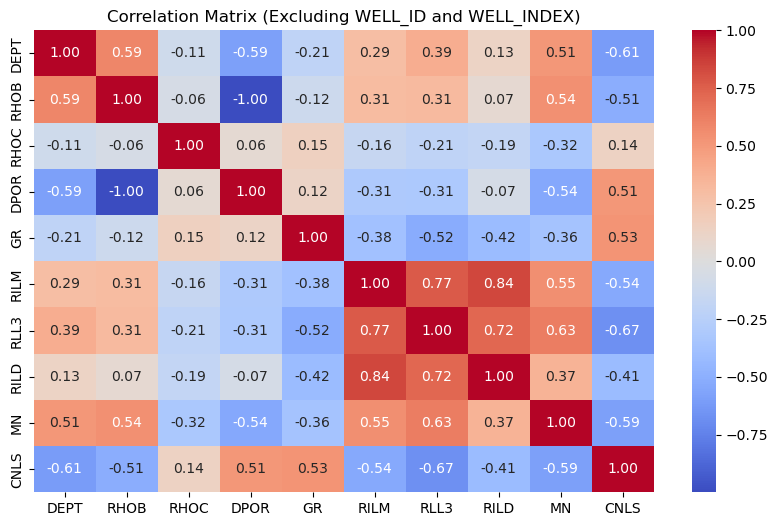

In [57]:
import seaborn as sn
import matplotlib.pyplot as plt

# Drop WELL_ID and WELL_INDEX before correlation
df_corr = df_final_knn.drop(columns=['WELL_ID', 'WELL_INDEX'], errors='ignore')  # errors='ignore' prevents crash if column missing

# Compute correlation only on numeric data
plt.figure(figsize=(10, 6))
sn.heatmap(df_corr.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix (Excluding WELL_ID and WELL_INDEX)")
plt.show()


In [59]:
#Add phi and sw
Rw = 0.1  # Formation water resistivity
a, m, n = 1, 2, 2  # Archie's constants

# Calculate porosity from DPHI
df_final_knn['phi'] = df_final_knn['DPOR'] / 100  # or just df['dpor'] if it's already in fraction

# Get Rt (resistivity) and handle divide-by-zero safely
Rt = df_final_knn['RILD'].replace(0, np.nan)

# Apply Archie's equation
df_final_knn['sw'] = ((a * Rw) / (df_final_knn['phi'] ** m * Rt)) ** (1 / n)
df_final_knn['sw'] = df_final_knn['sw'].clip(0, 1)  # constrain to [0, 1]

In [61]:
print(df_final_knn.head)

<bound method NDFrame.head of            DEPT     RHOB     RHOC      DPOR         GR     RILM      RLL3  \
1263797  3185.5  2.44338  0.05724  15.59248   61.69454  17.1619  11.00546   
1263798  3185.0  2.44338  0.05724  15.59248   61.69454  17.1619  11.00546   
1263799  3184.5  2.44338  0.05724  15.59248   61.69454  17.1619  11.00546   
1263800  3184.0  2.44338  0.05724  15.59248   61.69454  17.1619  11.00546   
1263801  3183.5  2.44338  0.05724  15.59248   61.69454  17.1619  11.00546   
...         ...      ...      ...       ...        ...      ...       ...   
577379   3553.0  2.56950  0.11420   8.21920  106.73256  17.1619  15.88848   
577380   3553.5  2.54270  0.10490   9.78280  106.73256  17.1619  15.88848   
577381   3554.0  2.46060  0.07750  14.58350  106.73256  17.1619  15.88848   
577382   3554.5  2.48260  0.04870  13.29810  106.73256  17.1619  15.88848   
577383   3555.0  2.61310  0.00760   5.66690  106.73256  17.1619  15.88848   

             RILD       MN      CNLS     WELL

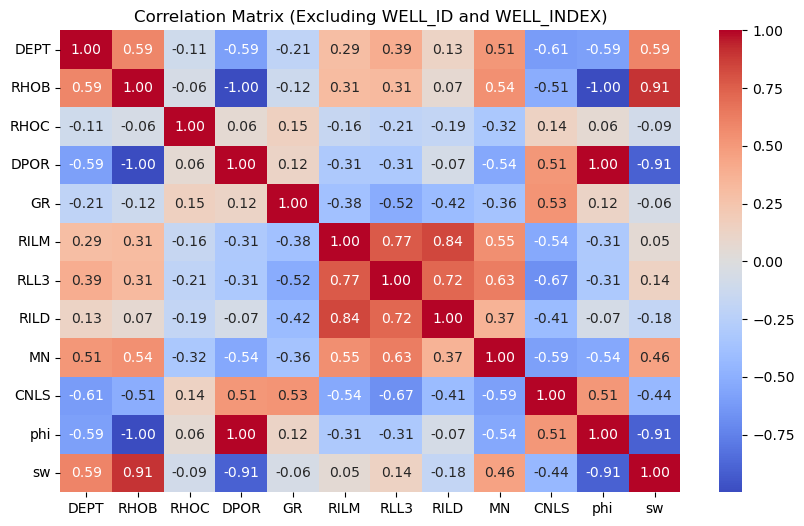

In [63]:
import seaborn as sn
import matplotlib.pyplot as plt

# Drop WELL_ID and WELL_INDEX before correlation
df_corr = df_final_knn.drop(columns=['WELL_ID', 'WELL_INDEX'], errors='ignore')  # errors='ignore' prevents crash if column missing

# Compute correlation only on numeric data
plt.figure(figsize=(10, 6))
sn.heatmap(df_corr.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix (Excluding WELL_ID and WELL_INDEX)")
plt.show()


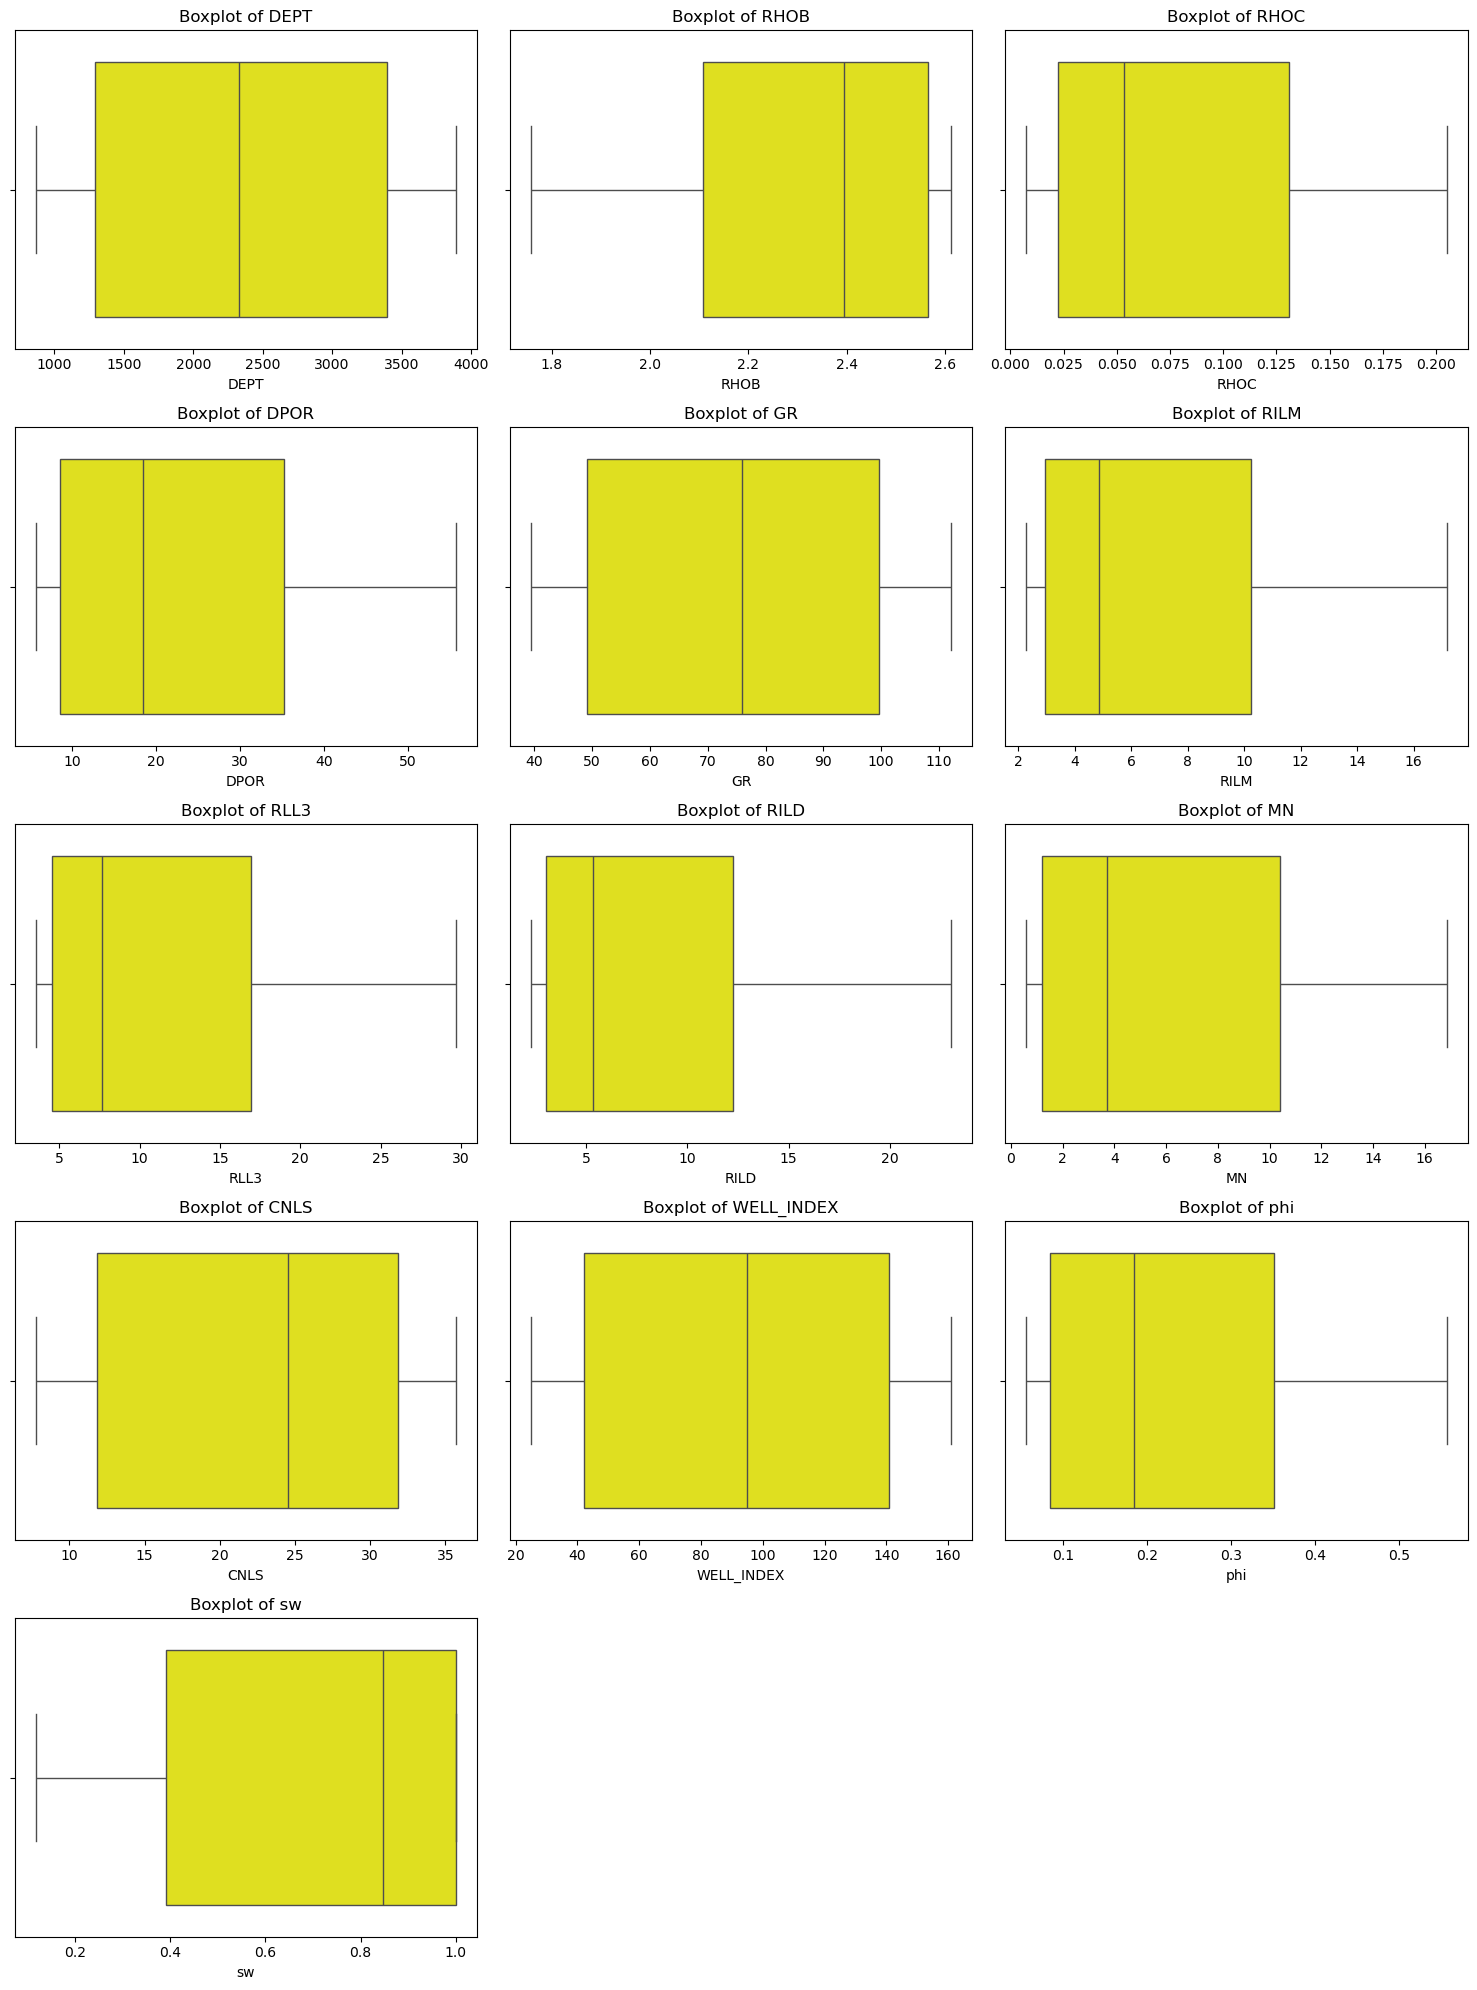

In [79]:
import math

numeric_cols = df_final_knn.select_dtypes(include='number').columns
n = len(numeric_cols)
cols = 3
rows = math.ceil(n / cols)

plt.figure(figsize=(5 * cols, 4 * rows))
for i, col in enumerate(numeric_cols):
    plt.subplot(rows, cols, i + 1)
    sn.boxplot(x=df_final_knn[col], color='yellow')
    plt.title(f"Boxplot of {col}")

plt.tight_layout()
plt.show()


In [67]:
# Save the final KNN-imputed dataset to CSV
df_final_knn.to_csv("knn_imputed_dataset_final.csv", index=False)
